# GANomaly
- 2020.08.16 : gen 4 / lr 1e-5

# 개발일지
- 2020.08.15 : 분율 추출 구현 / 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티타늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100  # z벡터의 잠재공간(latent space)의 크기
workers = 4    # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
#data_root = "../../dataset/train"
DP_aug_data_root = "../../dataset/aug_train/aug_DualPhaseSteel"

data_set = dataset.ImageFolder(root = DP_aug_data_root, # data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 990
device : cuda:0


# MODEL

In [4]:
# GANomaly : Generative Adversarial Networks Model using Decoder with AutoEncoder

# === Decoder 모델 ===
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def DC_conv_block(in_features, out_features):
            block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
            ]
            return block
        
        def DC_deconv_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.DC_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *DC_deconv_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *DC_conv_block(img_size*8, img_size*8),
            # ------ state size is 512x4x4 ------   
            *DC_deconv_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *DC_conv_block(img_size*4, img_size*4),
            # ------ state size is 256x8x8 ------ 
            *DC_deconv_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *DC_conv_block(img_size*2, img_size*2),
            # ------ state size is 128x16x16 ------ 
            *DC_deconv_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.DC_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1, 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.DC_gen_distribution(input)
        fake_img = self.DC_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *D_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *D_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *D_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *D_block(img_size*8, img_size*8, MP=True),
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature 


# === Encoder Model ===
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        def EC_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 ==============
        self.EC_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *EC_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *EC_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *EC_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *EC_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *EC_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *EC_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *EC_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *EC_block(img_size*8, img_size*8, MP=True),
        )
        
        # =============== Encoder Training layer ===============
        self.EC_validate = nn.Sequential(
            # -------state is 512 x 4 x 4-------
            nn.Conv2d(img_size*8, latent_size, 4, 1, 0, bias=False),
            nn.Tanh()
            # -------state is 100 x 97 x 97-------
        )
        
    def forward(self, input):
        feature = self.EC_extract_feature(input)
        validity = self.EC_validate(feature)
        
        return validity

# Loss & Optim

In [5]:
# DC and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,DC,EC 네트워크 모델 객체 선언
D = Discriminator().to(device)
DC = Decoder().to(device)
EC = Encoder().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
DC.apply(weights_init)
EC.apply(weights_init)

# Binary cross entropy loss and optimizer
DCGAN_criterion = nn.BCELoss()
AE_criterion = nn.MSELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 DC로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 DC에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
DC_optimizer = torch.optim.Adam(DC.parameters(), lr = learning_rate, betas=(0.5,0.999))
EC_optimizer = torch.optim.Adam(EC.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(DC)
#print(EC)

def reset_grad():
    D_optimizer.zero_grad()
    DC_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
DC_losses = []
D_losses = []
iters = 0

def train_DCGAN(epoch, learning_DC_per_D = 4):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train D
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = DCGAN_criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = DC(z)
        fake_classification, _ = D(fake_img) # output = D(DC(z))
        fake_loss = DCGAN_criterion(fake_classification, fake_labels) # D(DC(z))=0일 때의 loss
        fake_score = fake_classification
        D_DC_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(DC(z))=0이어야 D가 최적

        
        # Train DC
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_DC_per_D):
            fake_img = DC(z)
            fake_classification,_ = D(fake_img)  # output : D(DC(z))
            D_DC_z2 = fake_classification.mean().item()
            DC_loss = DCGAN_criterion(fake_classification, real_labels) # D(DC(z))=1일 때의 loss=log(D(DC(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            DC_loss.backward()
            DC_optimizer.step() # D(DC(z))=1 이어야 DC가 최적
            # ==> D(DC(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / DC_loss : %.4f\n- D(x):%.4f / D(DC(z1)) : %.4f / D(DC(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     DC_loss.item(),D_x,D_DC_z1,D_DC_z2))
        
        # Save Losses for plotting later
        DC_losses.append(DC_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [7]:
for epoch in range(epochs):
    train_DCGAN(epoch, learning_DC_per_D = 4)

/home/piai/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/15]
- D_loss : 1.3954 / DC_loss : 0.6628
- D(x):0.5038 / D(DC(z1)) : 0.5081 / D(DC(z2)) : 0.5155
[1/100][1/15]
- D_loss : 1.3814 / DC_loss : 0.6764
- D(x):0.5043 / D(DC(z1)) : 0.5016 / D(DC(z2)) : 0.5085
[1/100][2/15]
- D_loss : 1.3780 / DC_loss : 0.6785
- D(x):0.5049 / D(DC(z1)) : 0.5006 / D(DC(z2)) : 0.5074
[1/100][3/15]
- D_loss : 1.3678 / DC_loss : 0.6886
- D(x):0.5049 / D(DC(z1)) : 0.4955 / D(DC(z2)) : 0.5023
[1/100][4/15]
- D_loss : 1.3582 / DC_loss : 0.6997
- D(x):0.5038 / D(DC(z1)) : 0.4895 / D(DC(z2)) : 0.4968
[1/100][5/15]
- D_loss : 1.3470 / DC_loss : 0.7076
- D(x):0.5056 / D(DC(z1)) : 0.4856 / D(DC(z2)) : 0.4929
[1/100][6/15]
- D_loss : 1.3415 / DC_loss : 0.7145
- D(x):0.5045 / D(DC(z1)) : 0.4816 / D(DC(z2)) : 0.4895
[1/100][7/15]
- D_loss : 1.3375 / DC_loss : 0.7217
- D(x):0.5028 / D(DC(z1)) : 0.4779 / D(DC(z2)) : 0.4860
[1/100][8/15]
- D_loss : 1.3278 / DC_loss : 0.7285
- D(x):0.5050 / D(DC(z1)) : 0.4750 / D(DC(z2)) : 0.4827
[1/100][9/15]
- D_loss : 1.3213 / DC_

[6/100][2/15]
- D_loss : 1.1481 / DC_loss : 0.8819
- D(x):0.5437 / D(DC(z1)) : 0.4147 / D(DC(z2)) : 0.4158
[6/100][3/15]
- D_loss : 1.1384 / DC_loss : 0.8818
- D(x):0.5498 / D(DC(z1)) : 0.4148 / D(DC(z2)) : 0.4171
[6/100][4/15]
- D_loss : 1.1198 / DC_loss : 0.8875
- D(x):0.5559 / D(DC(z1)) : 0.4107 / D(DC(z2)) : 0.4137
[6/100][5/15]
- D_loss : 1.1286 / DC_loss : 0.8986
- D(x):0.5476 / D(DC(z1)) : 0.4068 / D(DC(z2)) : 0.4100
[6/100][6/15]
- D_loss : 1.1217 / DC_loss : 0.8948
- D(x):0.5531 / D(DC(z1)) : 0.4085 / D(DC(z2)) : 0.4124
[6/100][7/15]
- D_loss : 1.1088 / DC_loss : 0.8871
- D(x):0.5638 / D(DC(z1)) : 0.4118 / D(DC(z2)) : 0.4156
[6/100][8/15]
- D_loss : 1.1048 / DC_loss : 0.9018
- D(x):0.5596 / D(DC(z1)) : 0.4046 / D(DC(z2)) : 0.4092
[6/100][9/15]
- D_loss : 1.1059 / DC_loss : 0.8849
- D(x):0.5649 / D(DC(z1)) : 0.4105 / D(DC(z2)) : 0.4177
[6/100][10/15]
- D_loss : 1.0923 / DC_loss : 0.8689
- D(x):0.5735 / D(DC(z1)) : 0.4122 / D(DC(z2)) : 0.4229
[6/100][11/15]
- D_loss : 1.0867 / D

[11/100][4/15]
- D_loss : 0.9686 / DC_loss : 0.9716
- D(x):0.6281 / D(DC(z1)) : 0.3917 / D(DC(z2)) : 0.3801
[11/100][5/15]
- D_loss : 1.1020 / DC_loss : 0.9858
- D(x):0.5489 / D(DC(z1)) : 0.3889 / D(DC(z2)) : 0.3749
[11/100][6/15]
- D_loss : 1.0110 / DC_loss : 1.0131
- D(x):0.5913 / D(DC(z1)) : 0.3804 / D(DC(z2)) : 0.3642
[11/100][7/15]
- D_loss : 1.0388 / DC_loss : 1.0399
- D(x):0.5683 / D(DC(z1)) : 0.3709 / D(DC(z2)) : 0.3548
[11/100][8/15]
- D_loss : 0.9397 / DC_loss : 1.0713
- D(x):0.6129 / D(DC(z1)) : 0.3588 / D(DC(z2)) : 0.3434
[11/100][9/15]
- D_loss : 0.9531 / DC_loss : 1.0958
- D(x):0.5954 / D(DC(z1)) : 0.3478 / D(DC(z2)) : 0.3349
[11/100][10/15]
- D_loss : 0.8992 / DC_loss : 1.1211
- D(x):0.6181 / D(DC(z1)) : 0.3375 / D(DC(z2)) : 0.3266
[11/100][11/15]
- D_loss : 0.8890 / DC_loss : 1.1369
- D(x):0.6187 / D(DC(z1)) : 0.3302 / D(DC(z2)) : 0.3213
[11/100][12/15]
- D_loss : 0.9129 / DC_loss : 1.1489
- D(x):0.6001 / D(DC(z1)) : 0.3243 / D(DC(z2)) : 0.3174
[11/100][13/15]
- D_loss 

[16/100][5/15]
- D_loss : 0.5505 / DC_loss : 1.4328
- D(x):0.7618 / D(DC(z1)) : 0.2407 / D(DC(z2)) : 0.2389
[16/100][6/15]
- D_loss : 0.5848 / DC_loss : 1.4171
- D(x):0.7413 / D(DC(z1)) : 0.2450 / D(DC(z2)) : 0.2428
[16/100][7/15]
- D_loss : 0.5807 / DC_loss : 1.4035
- D(x):0.7490 / D(DC(z1)) : 0.2499 / D(DC(z2)) : 0.2461
[16/100][8/15]
- D_loss : 0.6319 / DC_loss : 1.3720
- D(x):0.7150 / D(DC(z1)) : 0.2528 / D(DC(z2)) : 0.2541
[16/100][9/15]
- D_loss : 0.6396 / DC_loss : 1.3216
- D(x):0.7215 / D(DC(z1)) : 0.2655 / D(DC(z2)) : 0.2672
[16/100][10/15]
- D_loss : 0.6276 / DC_loss : 1.3039
- D(x):0.7452 / D(DC(z1)) : 0.2812 / D(DC(z2)) : 0.2722
[16/100][11/15]
- D_loss : 0.6449 / DC_loss : 1.3340
- D(x):0.7354 / D(DC(z1)) : 0.2838 / D(DC(z2)) : 0.2639
[16/100][12/15]
- D_loss : 0.6501 / DC_loss : 1.3794
- D(x):0.7204 / D(DC(z1)) : 0.2732 / D(DC(z2)) : 0.2520
[16/100][13/15]
- D_loss : 0.6393 / DC_loss : 1.4259
- D(x):0.7156 / D(DC(z1)) : 0.2594 / D(DC(z2)) : 0.2407
[16/100][14/15]
- D_loss

[21/100][6/15]
- D_loss : 0.4506 / DC_loss : 1.6185
- D(x):0.8034 / D(DC(z1)) : 0.2034 / D(DC(z2)) : 0.1982
[21/100][7/15]
- D_loss : 0.4679 / DC_loss : 1.6239
- D(x):0.7878 / D(DC(z1)) : 0.2009 / D(DC(z2)) : 0.1972
[21/100][8/15]
- D_loss : 0.4443 / DC_loss : 1.6302
- D(x):0.8040 / D(DC(z1)) : 0.1993 / D(DC(z2)) : 0.1959
[21/100][9/15]
- D_loss : 0.4548 / DC_loss : 1.6319
- D(x):0.7942 / D(DC(z1)) : 0.1983 / D(DC(z2)) : 0.1956
[21/100][10/15]
- D_loss : 0.4361 / DC_loss : 1.6370
- D(x):0.8077 / D(DC(z1)) : 0.1978 / D(DC(z2)) : 0.1946
[21/100][11/15]
- D_loss : 0.4787 / DC_loss : 1.6373
- D(x):0.7755 / D(DC(z1)) : 0.1970 / D(DC(z2)) : 0.1945
[21/100][12/15]
- D_loss : 0.4123 / DC_loss : 1.6418
- D(x):0.8263 / D(DC(z1)) : 0.1971 / D(DC(z2)) : 0.1937
[21/100][13/15]
- D_loss : 0.4112 / DC_loss : 1.6466
- D(x):0.8269 / D(DC(z1)) : 0.1962 / D(DC(z2)) : 0.1927
[21/100][14/15]
- D_loss : 0.4164 / DC_loss : 1.6485
- D(x):0.8220 / D(DC(z1)) : 0.1954 / D(DC(z2)) : 0.1924
[22/100][0/15]
- D_loss

[26/100][7/15]
- D_loss : 0.2924 / DC_loss : 1.9995
- D(x):0.8656 / D(DC(z1)) : 0.1357 / D(DC(z2)) : 0.1355
[26/100][8/15]
- D_loss : 0.2753 / DC_loss : 1.9923
- D(x):0.8809 / D(DC(z1)) : 0.1372 / D(DC(z2)) : 0.1365
[26/100][9/15]
- D_loss : 0.2945 / DC_loss : 1.9768
- D(x):0.8662 / D(DC(z1)) : 0.1384 / D(DC(z2)) : 0.1386
[26/100][10/15]
- D_loss : 0.3142 / DC_loss : 1.9540
- D(x):0.8537 / D(DC(z1)) : 0.1409 / D(DC(z2)) : 0.1419
[26/100][11/15]
- D_loss : 0.2993 / DC_loss : 1.9337
- D(x):0.8690 / D(DC(z1)) : 0.1446 / D(DC(z2)) : 0.1447
[26/100][12/15]
- D_loss : 0.3095 / DC_loss : 1.9043
- D(x):0.8626 / D(DC(z1)) : 0.1480 / D(DC(z2)) : 0.1491
[26/100][13/15]
- D_loss : 0.3186 / DC_loss : 1.8680
- D(x):0.8602 / D(DC(z1)) : 0.1528 / D(DC(z2)) : 0.1545
[26/100][14/15]
- D_loss : 0.3039 / DC_loss : 1.8383
- D(x):0.8790 / D(DC(z1)) : 0.1594 / D(DC(z2)) : 0.1592
[27/100][0/15]
- D_loss : 0.3242 / DC_loss : 1.8240
- D(x):0.8671 / D(DC(z1)) : 0.1639 / D(DC(z2)) : 0.1615
[27/100][1/15]
- D_loss

[31/100][8/15]
- D_loss : 0.2630 / DC_loss : 1.9922
- D(x):0.8900 / D(DC(z1)) : 0.1354 / D(DC(z2)) : 0.1364
[31/100][9/15]
- D_loss : 0.2692 / DC_loss : 1.9599
- D(x):0.8893 / D(DC(z1)) : 0.1397 / D(DC(z2)) : 0.1409
[31/100][10/15]
- D_loss : 0.2910 / DC_loss : 1.9276
- D(x):0.8756 / D(DC(z1)) : 0.1445 / D(DC(z2)) : 0.1455
[31/100][11/15]
- D_loss : 0.2875 / DC_loss : 1.8805
- D(x):0.8838 / D(DC(z1)) : 0.1502 / D(DC(z2)) : 0.1526
[31/100][12/15]
- D_loss : 0.3159 / DC_loss : 1.8195
- D(x):0.8682 / D(DC(z1)) : 0.1582 / D(DC(z2)) : 0.1622
[31/100][13/15]
- D_loss : 0.2891 / DC_loss : 1.7830
- D(x):0.9036 / D(DC(z1)) : 0.1707 / D(DC(z2)) : 0.1682
[31/100][14/15]
- D_loss : 0.3260 / DC_loss : 1.7725
- D(x):0.8805 / D(DC(z1)) : 0.1791 / D(DC(z2)) : 0.1700
[32/100][0/15]
- D_loss : 0.3325 / DC_loss : 1.8076
- D(x):0.8791 / D(DC(z1)) : 0.1828 / D(DC(z2)) : 0.1641
[32/100][1/15]
- D_loss : 0.3066 / DC_loss : 1.9175
- D(x):0.8949 / D(DC(z1)) : 0.1762 / D(DC(z2)) : 0.1470
[32/100][2/15]
- D_loss

[36/100][9/15]
- D_loss : 0.2166 / DC_loss : 2.2724
- D(x):0.9081 / D(DC(z1)) : 0.1123 / D(DC(z2)) : 0.1031
[36/100][10/15]
- D_loss : 0.2360 / DC_loss : 2.3146
- D(x):0.8838 / D(DC(z1)) : 0.1049 / D(DC(z2)) : 0.0988
[36/100][11/15]
- D_loss : 0.2416 / DC_loss : 2.3238
- D(x):0.8756 / D(DC(z1)) : 0.1003 / D(DC(z2)) : 0.0979
[36/100][12/15]
- D_loss : 0.2251 / DC_loss : 2.3317
- D(x):0.8888 / D(DC(z1)) : 0.0994 / D(DC(z2)) : 0.0971
[36/100][13/15]
- D_loss : 0.2674 / DC_loss : 2.2864
- D(x):0.8539 / D(DC(z1)) : 0.0985 / D(DC(z2)) : 0.1016
[36/100][14/15]
- D_loss : 0.2231 / DC_loss : 2.2724
- D(x):0.8937 / D(DC(z1)) : 0.1034 / D(DC(z2)) : 0.1031
[37/100][0/15]
- D_loss : 0.2291 / DC_loss : 2.2735
- D(x):0.8903 / D(DC(z1)) : 0.1050 / D(DC(z2)) : 0.1030
[37/100][1/15]
- D_loss : 0.2086 / DC_loss : 2.3128
- D(x):0.9079 / D(DC(z1)) : 0.1051 / D(DC(z2)) : 0.0990
[37/100][2/15]
- D_loss : 0.2158 / DC_loss : 2.3352
- D(x):0.8976 / D(DC(z1)) : 0.1010 / D(DC(z2)) : 0.0968
[37/100][3/15]
- D_loss

[41/100][10/15]
- D_loss : 0.2969 / DC_loss : 2.2919
- D(x):0.8506 / D(DC(z1)) : 0.1225 / D(DC(z2)) : 0.1011
[41/100][11/15]
- D_loss : 0.5223 / DC_loss : 1.9116
- D(x):0.6819 / D(DC(z1)) : 0.1066 / D(DC(z2)) : 0.1479
[41/100][12/15]
- D_loss : 0.2741 / DC_loss : 2.0066
- D(x):0.9048 / D(DC(z1)) : 0.1584 / D(DC(z2)) : 0.1345
[41/100][13/15]
- D_loss : 0.2860 / DC_loss : 2.2155
- D(x):0.8784 / D(DC(z1)) : 0.1423 / D(DC(z2)) : 0.1091
[41/100][14/15]
- D_loss : 0.2269 / DC_loss : 2.3708
- D(x):0.9002 / D(DC(z1)) : 0.1132 / D(DC(z2)) : 0.0934
[42/100][0/15]
- D_loss : 0.2281 / DC_loss : 2.4323
- D(x):0.8826 / D(DC(z1)) : 0.0958 / D(DC(z2)) : 0.0878
[42/100][1/15]
- D_loss : 0.1981 / DC_loss : 2.4645
- D(x):0.9023 / D(DC(z1)) : 0.0897 / D(DC(z2)) : 0.0851
[42/100][2/15]
- D_loss : 0.2175 / DC_loss : 2.4385
- D(x):0.8825 / D(DC(z1)) : 0.0868 / D(DC(z2)) : 0.0873
[42/100][3/15]
- D_loss : 0.1768 / DC_loss : 2.4309
- D(x):0.9205 / D(DC(z1)) : 0.0893 / D(DC(z2)) : 0.0880
[42/100][4/15]
- D_loss

[46/100][11/15]
- D_loss : 0.5298 / DC_loss : 1.4184
- D(x):0.7764 / D(DC(z1)) : 0.2375 / D(DC(z2)) : 0.2421
[46/100][12/15]
- D_loss : 0.7088 / DC_loss : 1.2494
- D(x):0.6856 / D(DC(z1)) : 0.2738 / D(DC(z2)) : 0.2867
[46/100][13/15]
- D_loss : 0.6081 / DC_loss : 1.5742
- D(x):0.8225 / D(DC(z1)) : 0.3320 / D(DC(z2)) : 0.2072
[46/100][14/15]
- D_loss : 0.4428 / DC_loss : 1.9915
- D(x):0.8424 / D(DC(z1)) : 0.2348 / D(DC(z2)) : 0.1365
[47/100][0/15]
- D_loss : 0.5734 / DC_loss : 1.8637
- D(x):0.6712 / D(DC(z1)) : 0.1486 / D(DC(z2)) : 0.1551
[47/100][1/15]
- D_loss : 0.6868 / DC_loss : 1.3709
- D(x):0.6163 / D(DC(z1)) : 0.1693 / D(DC(z2)) : 0.2539
[47/100][2/15]
- D_loss : 0.4908 / DC_loss : 1.6350
- D(x):0.8559 / D(DC(z1)) : 0.2833 / D(DC(z2)) : 0.1950
[47/100][3/15]
- D_loss : 0.5648 / DC_loss : 1.8552
- D(x):0.7450 / D(DC(z1)) : 0.2122 / D(DC(z2)) : 0.1564
[47/100][4/15]
- D_loss : 0.3791 / DC_loss : 2.0282
- D(x):0.8261 / D(DC(z1)) : 0.1670 / D(DC(z2)) : 0.1316
[47/100][5/15]
- D_loss 

[51/100][12/15]
- D_loss : 0.3803 / DC_loss : 2.4512
- D(x):0.7870 / D(DC(z1)) : 0.1274 / D(DC(z2)) : 0.0862
[51/100][13/15]
- D_loss : 0.3214 / DC_loss : 2.3135
- D(x):0.8008 / D(DC(z1)) : 0.0916 / D(DC(z2)) : 0.0989
[51/100][14/15]
- D_loss : 0.3739 / DC_loss : 1.7344
- D(x):0.7779 / D(DC(z1)) : 0.1093 / D(DC(z2)) : 0.1765
[52/100][0/15]
- D_loss : 0.4178 / DC_loss : 1.9912
- D(x):0.8661 / D(DC(z1)) : 0.2378 / D(DC(z2)) : 0.1366
[52/100][1/15]
- D_loss : 0.3537 / DC_loss : 2.3311
- D(x):0.8505 / D(DC(z1)) : 0.1730 / D(DC(z2)) : 0.0972
[52/100][2/15]
- D_loss : 0.3848 / DC_loss : 2.2219
- D(x):0.7699 / D(DC(z1)) : 0.1099 / D(DC(z2)) : 0.1084
[52/100][3/15]
- D_loss : 0.4941 / DC_loss : 1.8021
- D(x):0.7010 / D(DC(z1)) : 0.1197 / D(DC(z2)) : 0.1650
[52/100][4/15]
- D_loss : 0.3268 / DC_loss : 1.9933
- D(x):0.8845 / D(DC(z1)) : 0.1832 / D(DC(z2)) : 0.1363
[52/100][5/15]
- D_loss : 0.4491 / DC_loss : 1.9714
- D(x):0.7567 / D(DC(z1)) : 0.1493 / D(DC(z2)) : 0.1393
[52/100][6/15]
- D_loss :

[56/100][13/15]
- D_loss : 0.1919 / DC_loss : 2.3988
- D(x):0.9091 / D(DC(z1)) : 0.0914 / D(DC(z2)) : 0.0908
[56/100][14/15]
- D_loss : 0.3207 / DC_loss : 2.0861
- D(x):0.8091 / D(DC(z1)) : 0.0980 / D(DC(z2)) : 0.1242
[57/100][0/15]
- D_loss : 0.2593 / DC_loss : 1.9872
- D(x):0.8958 / D(DC(z1)) : 0.1380 / D(DC(z2)) : 0.1371
[57/100][1/15]
- D_loss : 0.3226 / DC_loss : 2.0159
- D(x):0.8598 / D(DC(z1)) : 0.1547 / D(DC(z2)) : 0.1332
[57/100][2/15]
- D_loss : 0.3126 / DC_loss : 2.0664
- D(x):0.8643 / D(DC(z1)) : 0.1509 / D(DC(z2)) : 0.1266
[57/100][3/15]
- D_loss : 0.3189 / DC_loss : 2.0435
- D(x):0.8531 / D(DC(z1)) : 0.1443 / D(DC(z2)) : 0.1296
[57/100][4/15]
- D_loss : 0.3150 / DC_loss : 1.8746
- D(x):0.8635 / D(DC(z1)) : 0.1521 / D(DC(z2)) : 0.1534
[57/100][5/15]
- D_loss : 0.3397 / DC_loss : 1.4085
- D(x):0.8863 / D(DC(z1)) : 0.1954 / D(DC(z2)) : 0.2445
[57/100][6/15]
- D_loss : 0.5070 / DC_loss : 1.3247
- D(x):0.8985 / D(DC(z1)) : 0.3290 / D(DC(z2)) : 0.2659
[57/100][7/15]
- D_loss : 

[61/100][14/15]
- D_loss : 0.3164 / DC_loss : 1.9642
- D(x):0.8870 / D(DC(z1)) : 0.1774 / D(DC(z2)) : 0.1403
[62/100][0/15]
- D_loss : 0.3195 / DC_loss : 2.0906
- D(x):0.8560 / D(DC(z1)) : 0.1485 / D(DC(z2)) : 0.1236
[62/100][1/15]
- D_loss : 0.2812 / DC_loss : 2.1719
- D(x):0.8679 / D(DC(z1)) : 0.1285 / D(DC(z2)) : 0.1140
[62/100][2/15]
- D_loss : 0.3230 / DC_loss : 2.1703
- D(x):0.8257 / D(DC(z1)) : 0.1175 / D(DC(z2)) : 0.1142
[62/100][3/15]
- D_loss : 0.3366 / DC_loss : 2.1126
- D(x):0.8144 / D(DC(z1)) : 0.1177 / D(DC(z2)) : 0.1209
[62/100][4/15]
- D_loss : 0.2947 / DC_loss : 2.0684
- D(x):0.8531 / D(DC(z1)) : 0.1249 / D(DC(z2)) : 0.1264
[62/100][5/15]
- D_loss : 0.3499 / DC_loss : 2.0057
- D(x):0.8158 / D(DC(z1)) : 0.1308 / D(DC(z2)) : 0.1346
[62/100][6/15]
- D_loss : 0.3281 / DC_loss : 1.9789
- D(x):0.8415 / D(DC(z1)) : 0.1397 / D(DC(z2)) : 0.1382
[62/100][7/15]
- D_loss : 0.2514 / DC_loss : 2.0402
- D(x):0.9094 / D(DC(z1)) : 0.1442 / D(DC(z2)) : 0.1300
[62/100][8/15]
- D_loss : 0

[67/100][0/15]
- D_loss : 0.1967 / DC_loss : 2.4813
- D(x):0.8983 / D(DC(z1)) : 0.0842 / D(DC(z2)) : 0.0836
[67/100][1/15]
- D_loss : 0.1966 / DC_loss : 2.4536
- D(x):0.9004 / D(DC(z1)) : 0.0861 / D(DC(z2)) : 0.0860
[67/100][2/15]
- D_loss : 0.2125 / DC_loss : 2.3959
- D(x):0.8913 / D(DC(z1)) : 0.0888 / D(DC(z2)) : 0.0911
[67/100][3/15]
- D_loss : 0.2183 / DC_loss : 2.3742
- D(x):0.8895 / D(DC(z1)) : 0.0945 / D(DC(z2)) : 0.0931
[67/100][4/15]
- D_loss : 0.1674 / DC_loss : 2.4818
- D(x):0.9372 / D(DC(z1)) : 0.0970 / D(DC(z2)) : 0.0836
[67/100][5/15]
- D_loss : 0.1854 / DC_loss : 2.5533
- D(x):0.9111 / D(DC(z1)) : 0.0869 / D(DC(z2)) : 0.0778
[67/100][6/15]
- D_loss : 0.2115 / DC_loss : 2.4985
- D(x):0.8842 / D(DC(z1)) : 0.0808 / D(DC(z2)) : 0.0822
[67/100][7/15]
- D_loss : 0.1743 / DC_loss : 2.4936
- D(x):0.9200 / D(DC(z1)) : 0.0855 / D(DC(z2)) : 0.0826
[67/100][8/15]
- D_loss : 0.1626 / DC_loss : 2.5494
- D(x):0.9302 / D(DC(z1)) : 0.0858 / D(DC(z2)) : 0.0781
[67/100][9/15]
- D_loss : 0.

[72/100][1/15]
- D_loss : 0.3703 / DC_loss : 1.8115
- D(x):0.8367 / D(DC(z1)) : 0.1635 / D(DC(z2)) : 0.1634
[72/100][2/15]
- D_loss : 0.3599 / DC_loss : 1.7279
- D(x):0.8724 / D(DC(z1)) : 0.1951 / D(DC(z2)) : 0.1777
[72/100][3/15]
- D_loss : 0.4289 / DC_loss : 1.7465
- D(x):0.8399 / D(DC(z1)) : 0.2130 / D(DC(z2)) : 0.1744
[72/100][4/15]
- D_loss : 0.3245 / DC_loss : 1.9180
- D(x):0.9129 / D(DC(z1)) : 0.2059 / D(DC(z2)) : 0.1469
[72/100][5/15]
- D_loss : 0.4408 / DC_loss : 1.8287
- D(x):0.7934 / D(DC(z1)) : 0.1736 / D(DC(z2)) : 0.1606
[72/100][6/15]
- D_loss : 0.3727 / DC_loss : 1.8443
- D(x):0.8522 / D(DC(z1)) : 0.1872 / D(DC(z2)) : 0.1581
[72/100][7/15]
- D_loss : 0.6385 / DC_loss : 1.5720
- D(x):0.6690 / D(DC(z1)) : 0.1820 / D(DC(z2)) : 0.2076
[72/100][8/15]
- D_loss : 0.3750 / DC_loss : 1.9970
- D(x):0.9018 / D(DC(z1)) : 0.2358 / D(DC(z2)) : 0.1357
[72/100][9/15]
- D_loss : 0.2917 / DC_loss : 2.3538
- D(x):0.8796 / D(DC(z1)) : 0.1491 / D(DC(z2)) : 0.0950
[72/100][10/15]
- D_loss : 0

[77/100][2/15]
- D_loss : 0.2803 / DC_loss : 2.3074
- D(x):0.8827 / D(DC(z1)) : 0.1411 / D(DC(z2)) : 0.0995
[77/100][3/15]
- D_loss : 0.2728 / DC_loss : 2.3567
- D(x):0.8617 / D(DC(z1)) : 0.1130 / D(DC(z2)) : 0.0947
[77/100][4/15]
- D_loss : 0.2256 / DC_loss : 2.4298
- D(x):0.8955 / D(DC(z1)) : 0.1047 / D(DC(z2)) : 0.0881
[77/100][5/15]
- D_loss : 0.2547 / DC_loss : 2.3956
- D(x):0.8645 / D(DC(z1)) : 0.0954 / D(DC(z2)) : 0.0911
[77/100][6/15]
- D_loss : 0.3190 / DC_loss : 2.1519
- D(x):0.8118 / D(DC(z1)) : 0.0979 / D(DC(z2)) : 0.1163
[77/100][7/15]
- D_loss : 0.2145 / DC_loss : 2.2222
- D(x):0.9236 / D(DC(z1)) : 0.1258 / D(DC(z2)) : 0.1084
[77/100][8/15]
- D_loss : 0.2376 / DC_loss : 2.3146
- D(x):0.8939 / D(DC(z1)) : 0.1165 / D(DC(z2)) : 0.0988
[77/100][9/15]
- D_loss : 0.2694 / DC_loss : 2.2827
- D(x):0.8569 / D(DC(z1)) : 0.1052 / D(DC(z2)) : 0.1020
[77/100][10/15]
- D_loss : 0.2061 / DC_loss : 2.2333
- D(x):0.9159 / D(DC(z1)) : 0.1102 / D(DC(z2)) : 0.1072
[77/100][11/15]
- D_loss : 

[82/100][3/15]
- D_loss : 0.1555 / DC_loss : 2.6979
- D(x):0.9185 / D(DC(z1)) : 0.0671 / D(DC(z2)) : 0.0673
[82/100][4/15]
- D_loss : 0.1578 / DC_loss : 2.6717
- D(x):0.9185 / D(DC(z1)) : 0.0684 / D(DC(z2)) : 0.0691
[82/100][5/15]
- D_loss : 0.1490 / DC_loss : 2.6581
- D(x):0.9277 / D(DC(z1)) : 0.0708 / D(DC(z2)) : 0.0701
[82/100][6/15]
- D_loss : 0.1177 / DC_loss : 2.6919
- D(x):0.9581 / D(DC(z1)) : 0.0721 / D(DC(z2)) : 0.0678
[82/100][7/15]
- D_loss : 0.1229 / DC_loss : 2.7416
- D(x):0.9501 / D(DC(z1)) : 0.0691 / D(DC(z2)) : 0.0645
[82/100][8/15]
- D_loss : 0.1246 / DC_loss : 2.7811
- D(x):0.9454 / D(DC(z1)) : 0.0655 / D(DC(z2)) : 0.0620
[82/100][9/15]
- D_loss : 0.1030 / DC_loss : 2.8305
- D(x):0.9629 / D(DC(z1)) : 0.0631 / D(DC(z2)) : 0.0590
[82/100][10/15]
- D_loss : 0.1228 / DC_loss : 2.8675
- D(x):0.9461 / D(DC(z1)) : 0.0598 / D(DC(z2)) : 0.0568
[82/100][11/15]
- D_loss : 0.1281 / DC_loss : 2.8672
- D(x):0.9375 / D(DC(z1)) : 0.0575 / D(DC(z2)) : 0.0569
[82/100][12/15]
- D_loss :

[87/100][4/15]
- D_loss : 0.1187 / DC_loss : 3.0664
- D(x):0.9377 / D(DC(z1)) : 0.0524 / D(DC(z2)) : 0.0466
[87/100][5/15]
- D_loss : 0.0950 / DC_loss : 3.1749
- D(x):0.9554 / D(DC(z1)) : 0.0480 / D(DC(z2)) : 0.0418
[87/100][6/15]
- D_loss : 0.1084 / DC_loss : 3.2202
- D(x):0.9379 / D(DC(z1)) : 0.0429 / D(DC(z2)) : 0.0399
[87/100][7/15]
- D_loss : 0.1537 / DC_loss : 3.0915
- D(x):0.8988 / D(DC(z1)) : 0.0409 / D(DC(z2)) : 0.0454
[87/100][8/15]
- D_loss : 0.1024 / DC_loss : 3.0519
- D(x):0.9471 / D(DC(z1)) : 0.0466 / D(DC(z2)) : 0.0473
[87/100][9/15]
- D_loss : 0.1181 / DC_loss : 3.0496
- D(x):0.9353 / D(DC(z1)) : 0.0486 / D(DC(z2)) : 0.0474
[87/100][10/15]
- D_loss : 0.1013 / DC_loss : 3.1183
- D(x):0.9504 / D(DC(z1)) : 0.0486 / D(DC(z2)) : 0.0442
[87/100][11/15]
- D_loss : 0.1248 / DC_loss : 3.1340
- D(x):0.9258 / D(DC(z1)) : 0.0452 / D(DC(z2)) : 0.0435
[87/100][12/15]
- D_loss : 0.1427 / DC_loss : 3.0673
- D(x):0.9116 / D(DC(z1)) : 0.0445 / D(DC(z2)) : 0.0465
[87/100][13/15]
- D_loss 

[92/100][5/15]
- D_loss : 0.0960 / DC_loss : 3.0859
- D(x):0.9520 / D(DC(z1)) : 0.0453 / D(DC(z2)) : 0.0457
[92/100][6/15]
- D_loss : 0.0806 / DC_loss : 3.0929
- D(x):0.9678 / D(DC(z1)) : 0.0466 / D(DC(z2)) : 0.0454
[92/100][7/15]
- D_loss : 0.0862 / DC_loss : 3.0877
- D(x):0.9618 / D(DC(z1)) : 0.0459 / D(DC(z2)) : 0.0456
[92/100][8/15]
- D_loss : 0.0884 / DC_loss : 3.0906
- D(x):0.9602 / D(DC(z1)) : 0.0464 / D(DC(z2)) : 0.0455
[92/100][9/15]
- D_loss : 0.1247 / DC_loss : 3.0279
- D(x):0.9273 / D(DC(z1)) : 0.0466 / D(DC(z2)) : 0.0484
[92/100][10/15]
- D_loss : 0.0977 / DC_loss : 2.9783
- D(x):0.9540 / D(DC(z1)) : 0.0488 / D(DC(z2)) : 0.0509
[92/100][11/15]
- D_loss : 0.0953 / DC_loss : 2.9749
- D(x):0.9594 / D(DC(z1)) : 0.0522 / D(DC(z2)) : 0.0511
[92/100][12/15]
- D_loss : 0.0831 / DC_loss : 3.0119
- D(x):0.9715 / D(DC(z1)) : 0.0526 / D(DC(z2)) : 0.0492
[92/100][13/15]
- D_loss : 0.0846 / DC_loss : 3.0461
- D(x):0.9676 / D(DC(z1)) : 0.0502 / D(DC(z2)) : 0.0475
[92/100][14/15]
- D_loss

[97/100][6/15]
- D_loss : 0.1660 / DC_loss : 2.8426
- D(x):0.8984 / D(DC(z1)) : 0.0547 / D(DC(z2)) : 0.0583
[97/100][7/15]
- D_loss : 0.1225 / DC_loss : 2.8343
- D(x):0.9434 / D(DC(z1)) : 0.0607 / D(DC(z2)) : 0.0588
[97/100][8/15]
- D_loss : 0.0897 / DC_loss : 2.9432
- D(x):0.9737 / D(DC(z1)) : 0.0611 / D(DC(z2)) : 0.0527
[97/100][9/15]
- D_loss : 0.2484 / DC_loss : 2.6167
- D(x):0.8369 / D(DC(z1)) : 0.0546 / D(DC(z2)) : 0.0730
[97/100][10/15]
- D_loss : 0.1173 / DC_loss : 2.6306
- D(x):0.9633 / D(DC(z1)) : 0.0766 / D(DC(z2)) : 0.0720
[97/100][11/15]
- D_loss : 0.1039 / DC_loss : 2.8605
- D(x):0.9764 / D(DC(z1)) : 0.0768 / D(DC(z2)) : 0.0572
[97/100][12/15]
- D_loss : 0.1091 / DC_loss : 3.0682
- D(x):0.9547 / D(DC(z1)) : 0.0592 / D(DC(z2)) : 0.0465
[97/100][13/15]
- D_loss : 0.1139 / DC_loss : 3.1270
- D(x):0.9395 / D(DC(z1)) : 0.0484 / D(DC(z2)) : 0.0439
[97/100][14/15]
- D_loss : 0.0792 / DC_loss : 3.1804
- D(x):0.9688 / D(DC(z1)) : 0.0457 / D(DC(z2)) : 0.0416
[98/100][0/15]
- D_loss

# Animation

In [8]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

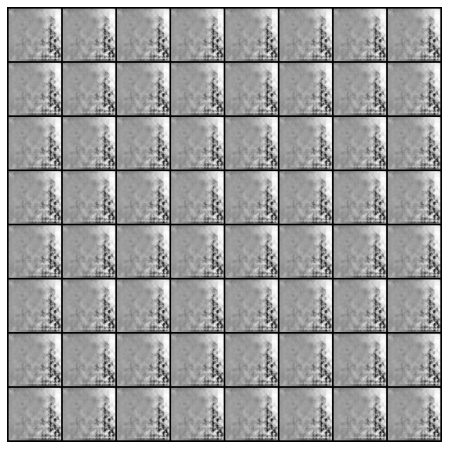

In [9]:
animate_gen_imgs()

# Trian : izif E

In [10]:
DC.eval()
D.eval()

kappa = 1.0
EC_losses = []

iters = 0
AE_img_list = []

def train_AE(epoch):
    global epochs
    global iters
    global EC_losses
    global AE_img_list
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        real_imgs = data[0].to(device)
        
        EC_optimizer.zero_grad()
        
        EC_validity = EC(real_imgs)
        
        fake_imgs = DC(EC_validity)
        
        _, real_features = D.forward(real_imgs)
        _, fake_features = D.forward(fake_imgs)
        
        
        # izif architecture
        imgs_loss = AE_criterion(real_imgs, fake_imgs)
        features_loss = AE_criterion(real_features, fake_features)
        EC_loss = imgs_loss + kappa*features_loss
        
        EC_loss.backward()
        EC_optimizer.step()
        
        # =============================================================
        # print
        # =============================================================
        print('[%d/%d][%d/%d]\n- E_loss: %.4f\n'
              %(epoch+1, epochs, i, len(data_loader), EC_loss.item()))
        
        # Save Losses for plotting later
        EC_losses.append(EC_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(EC_validity).detach().cpu()
            AE_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [11]:
for epoch in range(epochs):
    train_AE(epoch)

[1/100][0/15]
- E_loss: 0.1486

[1/100][1/15]
- E_loss: 0.1387

[1/100][2/15]
- E_loss: 0.1279

[1/100][3/15]
- E_loss: 0.1371

[1/100][4/15]
- E_loss: 0.1338

[1/100][5/15]
- E_loss: 0.1202

[1/100][6/15]
- E_loss: 0.1476

[1/100][7/15]
- E_loss: 0.1299

[1/100][8/15]
- E_loss: 0.1280

[1/100][9/15]
- E_loss: 0.1252

[1/100][10/15]
- E_loss: 0.1256

[1/100][11/15]
- E_loss: 0.1189

[1/100][12/15]
- E_loss: 0.1431

[1/100][13/15]
- E_loss: 0.1449

[1/100][14/15]
- E_loss: 0.1315

[2/100][0/15]
- E_loss: 0.1148

[2/100][1/15]
- E_loss: 0.1402

[2/100][2/15]
- E_loss: 0.1474

[2/100][3/15]
- E_loss: 0.1187

[2/100][4/15]
- E_loss: 0.1439

[2/100][5/15]
- E_loss: 0.1329

[2/100][6/15]
- E_loss: 0.1376

[2/100][7/15]
- E_loss: 0.1324

[2/100][8/15]
- E_loss: 0.1398

[2/100][9/15]
- E_loss: 0.1320

[2/100][10/15]
- E_loss: 0.1263

[2/100][11/15]
- E_loss: 0.1324

[2/100][12/15]
- E_loss: 0.1471

[2/100][13/15]
- E_loss: 0.1192

[2/100][14/15]
- E_loss: 0.1255

[3/100][0/15]
- E_loss: 0.1347

[17/100][10/15]
- E_loss: 0.1478

[17/100][11/15]
- E_loss: 0.1194

[17/100][12/15]
- E_loss: 0.1308

[17/100][13/15]
- E_loss: 0.1446

[17/100][14/15]
- E_loss: 0.1317

[18/100][0/15]
- E_loss: 0.1264

[18/100][1/15]
- E_loss: 0.1339

[18/100][2/15]
- E_loss: 0.1242

[18/100][3/15]
- E_loss: 0.1405

[18/100][4/15]
- E_loss: 0.1479

[18/100][5/15]
- E_loss: 0.1336

[18/100][6/15]
- E_loss: 0.1441

[18/100][7/15]
- E_loss: 0.1255

[18/100][8/15]
- E_loss: 0.1259

[18/100][9/15]
- E_loss: 0.1418

[18/100][10/15]
- E_loss: 0.1325

[18/100][11/15]
- E_loss: 0.1229

[18/100][12/15]
- E_loss: 0.1241

[18/100][13/15]
- E_loss: 0.1382

[18/100][14/15]
- E_loss: 0.1392

[19/100][0/15]
- E_loss: 0.1312

[19/100][1/15]
- E_loss: 0.1513

[19/100][2/15]
- E_loss: 0.1194

[19/100][3/15]
- E_loss: 0.1226

[19/100][4/15]
- E_loss: 0.1397

[19/100][5/15]
- E_loss: 0.1363

[19/100][6/15]
- E_loss: 0.1303

[19/100][7/15]
- E_loss: 0.1354

[19/100][8/15]
- E_loss: 0.1202

[19/100][9/15]
- E_loss: 0.1410



[34/100][1/15]
- E_loss: 0.1366

[34/100][2/15]
- E_loss: 0.1224

[34/100][3/15]
- E_loss: 0.1288

[34/100][4/15]
- E_loss: 0.1511

[34/100][5/15]
- E_loss: 0.1404

[34/100][6/15]
- E_loss: 0.1273

[34/100][7/15]
- E_loss: 0.1283

[34/100][8/15]
- E_loss: 0.1361

[34/100][9/15]
- E_loss: 0.1290

[34/100][10/15]
- E_loss: 0.1217

[34/100][11/15]
- E_loss: 0.1291

[34/100][12/15]
- E_loss: 0.1293

[34/100][13/15]
- E_loss: 0.1422

[34/100][14/15]
- E_loss: 0.1491

[35/100][0/15]
- E_loss: 0.1263

[35/100][1/15]
- E_loss: 0.1182

[35/100][2/15]
- E_loss: 0.1323

[35/100][3/15]
- E_loss: 0.1285

[35/100][4/15]
- E_loss: 0.1240

[35/100][5/15]
- E_loss: 0.1187

[35/100][6/15]
- E_loss: 0.1265

[35/100][7/15]
- E_loss: 0.1274

[35/100][8/15]
- E_loss: 0.1353

[35/100][9/15]
- E_loss: 0.1458

[35/100][10/15]
- E_loss: 0.1476

[35/100][11/15]
- E_loss: 0.1538

[35/100][12/15]
- E_loss: 0.1255

[35/100][13/15]
- E_loss: 0.1414

[35/100][14/15]
- E_loss: 0.1441

[36/100][0/15]
- E_loss: 0.1358



[50/100][7/15]
- E_loss: 0.1312

[50/100][8/15]
- E_loss: 0.1196

[50/100][9/15]
- E_loss: 0.1250

[50/100][10/15]
- E_loss: 0.1094

[50/100][11/15]
- E_loss: 0.1532

[50/100][12/15]
- E_loss: 0.1379

[50/100][13/15]
- E_loss: 0.1145

[50/100][14/15]
- E_loss: 0.1294

[51/100][0/15]
- E_loss: 0.1374

[51/100][1/15]
- E_loss: 0.1096

[51/100][2/15]
- E_loss: 0.1135

[51/100][3/15]
- E_loss: 0.1464

[51/100][4/15]
- E_loss: 0.1431

[51/100][5/15]
- E_loss: 0.1465

[51/100][6/15]
- E_loss: 0.1369

[51/100][7/15]
- E_loss: 0.1329

[51/100][8/15]
- E_loss: 0.1233

[51/100][9/15]
- E_loss: 0.1420

[51/100][10/15]
- E_loss: 0.1396

[51/100][11/15]
- E_loss: 0.1277

[51/100][12/15]
- E_loss: 0.1191

[51/100][13/15]
- E_loss: 0.1292

[51/100][14/15]
- E_loss: 0.1487

[52/100][0/15]
- E_loss: 0.1186

[52/100][1/15]
- E_loss: 0.1375

[52/100][2/15]
- E_loss: 0.1282

[52/100][3/15]
- E_loss: 0.1487

[52/100][4/15]
- E_loss: 0.1464

[52/100][5/15]
- E_loss: 0.1315

[52/100][6/15]
- E_loss: 0.1375



[66/100][13/15]
- E_loss: 0.1481

[66/100][14/15]
- E_loss: 0.1255

[67/100][0/15]
- E_loss: 0.1584

[67/100][1/15]
- E_loss: 0.1359

[67/100][2/15]
- E_loss: 0.1227

[67/100][3/15]
- E_loss: 0.1286

[67/100][4/15]
- E_loss: 0.1094

[67/100][5/15]
- E_loss: 0.1250

[67/100][6/15]
- E_loss: 0.1383

[67/100][7/15]
- E_loss: 0.1092

[67/100][8/15]
- E_loss: 0.1344

[67/100][9/15]
- E_loss: 0.1423

[67/100][10/15]
- E_loss: 0.1227

[67/100][11/15]
- E_loss: 0.1268

[67/100][12/15]
- E_loss: 0.1497

[67/100][13/15]
- E_loss: 0.1460

[67/100][14/15]
- E_loss: 0.1464

[68/100][0/15]
- E_loss: 0.1331

[68/100][1/15]
- E_loss: 0.1033

[68/100][2/15]
- E_loss: 0.1232

[68/100][3/15]
- E_loss: 0.1235

[68/100][4/15]
- E_loss: 0.1708

[68/100][5/15]
- E_loss: 0.1366

[68/100][6/15]
- E_loss: 0.1327

[68/100][7/15]
- E_loss: 0.1219

[68/100][8/15]
- E_loss: 0.1296

[68/100][9/15]
- E_loss: 0.1311

[68/100][10/15]
- E_loss: 0.1386

[68/100][11/15]
- E_loss: 0.1338

[68/100][12/15]
- E_loss: 0.1518



[83/100][4/15]
- E_loss: 0.1269

[83/100][5/15]
- E_loss: 0.1507

[83/100][6/15]
- E_loss: 0.1227

[83/100][7/15]
- E_loss: 0.1355

[83/100][8/15]
- E_loss: 0.1339

[83/100][9/15]
- E_loss: 0.1183

[83/100][10/15]
- E_loss: 0.1267

[83/100][11/15]
- E_loss: 0.1269

[83/100][12/15]
- E_loss: 0.1488

[83/100][13/15]
- E_loss: 0.1493

[83/100][14/15]
- E_loss: 0.1268

[84/100][0/15]
- E_loss: 0.1304

[84/100][1/15]
- E_loss: 0.1384

[84/100][2/15]
- E_loss: 0.1475

[84/100][3/15]
- E_loss: 0.1477

[84/100][4/15]
- E_loss: 0.1156

[84/100][5/15]
- E_loss: 0.1434

[84/100][6/15]
- E_loss: 0.1154

[84/100][7/15]
- E_loss: 0.1691

[84/100][8/15]
- E_loss: 0.1384

[84/100][9/15]
- E_loss: 0.1455

[84/100][10/15]
- E_loss: 0.1196

[84/100][11/15]
- E_loss: 0.1294

[84/100][12/15]
- E_loss: 0.1299

[84/100][13/15]
- E_loss: 0.1022

[84/100][14/15]
- E_loss: 0.1260

[85/100][0/15]
- E_loss: 0.1284

[85/100][1/15]
- E_loss: 0.1349

[85/100][2/15]
- E_loss: 0.1438

[85/100][3/15]
- E_loss: 0.1275



[99/100][10/15]
- E_loss: 0.1175

[99/100][11/15]
- E_loss: 0.1413

[99/100][12/15]
- E_loss: 0.1201

[99/100][13/15]
- E_loss: 0.1405

[99/100][14/15]
- E_loss: 0.1349

[100/100][0/15]
- E_loss: 0.1255

[100/100][1/15]
- E_loss: 0.1349

[100/100][2/15]
- E_loss: 0.1361

[100/100][3/15]
- E_loss: 0.1314

[100/100][4/15]
- E_loss: 0.1372

[100/100][5/15]
- E_loss: 0.1252

[100/100][6/15]
- E_loss: 0.1527

[100/100][7/15]
- E_loss: 0.1410

[100/100][8/15]
- E_loss: 0.1399

[100/100][9/15]
- E_loss: 0.1309

[100/100][10/15]
- E_loss: 0.1314

[100/100][11/15]
- E_loss: 0.1265

[100/100][12/15]
- E_loss: 0.1310

[100/100][13/15]
- E_loss: 0.1250

[100/100][14/15]
- E_loss: 0.1285



# Loss Graph

In [12]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(DC_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.plot(EC_losses, label="E")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

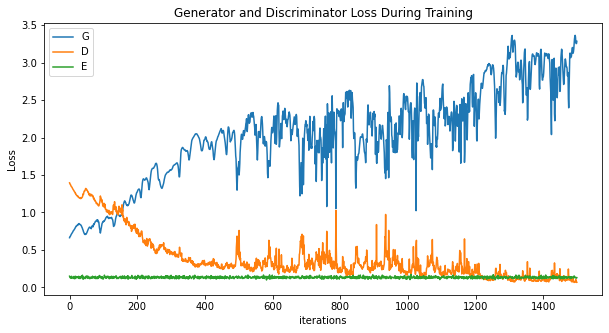

In [13]:
plot_train_loss()

---

# Test Data

In [14]:
#test_data_root = "../../dataset/test/test_DualPhaseSteel"
DP_test_data_root = "../../dataset/test/test_DualPhaseSteel"

test_data_set = dataset.ImageFolder(root = DP_test_data_root, # test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# img 비교 함수

In [16]:
def compare_imgs(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    
    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img

    diff_img[diff_img <= threshold] = 0

    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)

    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)

    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

# Test

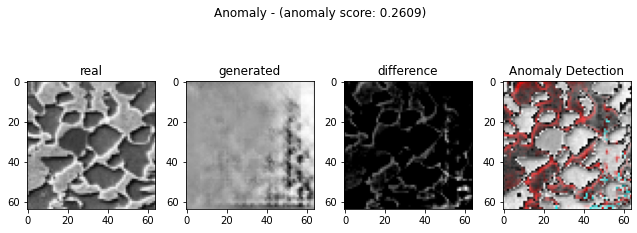

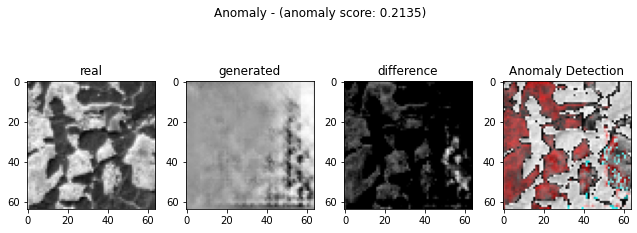

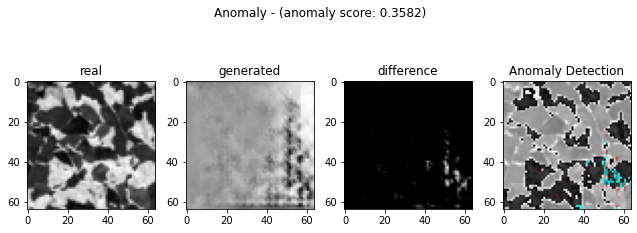

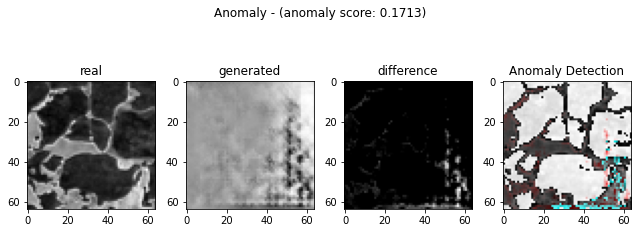

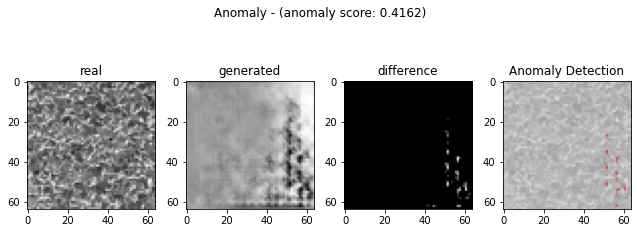

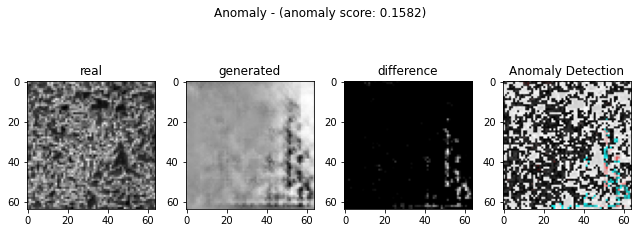

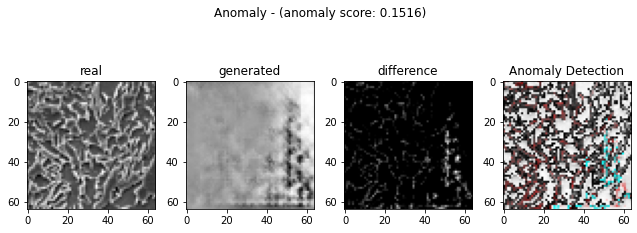

In [17]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

ano_criterion = nn.MSELoss()
DC.eval()
D.eval()
EC.eval()

# with open("score.csv", "w") as f:
#         f.write("label,img_distance,anomaly_score,z_distance\n")

for i, data in enumerate(test_data_loader, 0):
    real_img = data[0].to(device)

    real_z = EC(real_img) # 진짜 이미지의 latent vector
    fake_img = DC(real_z) # DC에 넣어서 가짜 이미지 생성.
    fake_z = EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    _, real_feature = D.forward(real_img) # 1, 256
    _, fake_feature = D.forward(fake_img)

    img_distance = ano_criterion(fake_img, real_img)
    loss_feature = ano_criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = ano_criterion(fake_z, real_z)
    
#     with open("score.csv", "a") as f:
#             f.write(f"{label.item()},{img_distance},"
#                     f"{anomaly_score},{z_distance}\n")
            
#     print(f"{label.item()}, {img_distance}, "
#           f"{anomaly_score}, {z_distance}\n")
    compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.35131836 0.41674805 0.05444336 0.17871094 0.01855469 0.07055664
 0.23120117]


In [19]:
sum(diff_fraction)/len(diff_fraction)

0.18879045758928573

---

# 분산 추출

In [20]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [21]:
cal_corr_coeffis()

print(corr_coeffis)

[0.1831385831826695, 0.20072027804381065, 0.13222580393629021, 0.2930608194983925, 0.066183251941719, 0.3387781264476453, 0.17352231268057053]


---

# 모델 저장 및 읽기

In [22]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "DC" : DC.state_dict(),
        "EC" : EC.state_dict()
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [23]:
save_pretrained()

In [24]:
pretrained_D = Discriminator().to(device)
pretrained_DC = Decoder().to(device)
pretrained_EC = Encoder().to(device)

def load_pretrained():
    global pretrained_D
    global pretrained_DC
    global pretrained_EC
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_DC.load_state_dict(pretrained["DC"])
    pretrained_EC.load_state_dict(pretrained["EC"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_DC)
    #print("pretrained_E :", pretrained_EC)

In [25]:
load_pretrained()

In [26]:
def test():
    ano_criterion = nn.MSELoss()
    pretrained_DC.eval()
    pretrained_D.eval()
    pretrained_EC.eval()

    # with open("score.csv", "w") as f:
    #         f.write("label,img_distance,anomaly_score,z_distance\n")

    for i, data in enumerate(test_data_loader, 0):
        real_img = data[0].to(device)

        real_z = pretrained_EC(real_img) # 진짜 이미지의 latent vector
        fake_img = pretrained_DC(real_z) # DC에 넣어서 가짜 이미지 생성.
        fake_z = pretrained_EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

        _, real_feature = pretrained_D.forward(real_img) # 1, 256
        _, fake_feature = pretrained_D.forward(fake_img)

        img_distance = ano_criterion(fake_img, real_img)
        loss_feature = ano_criterion(fake_feature, real_feature)

        anomaly_score = img_distance + kappa*loss_feature

        z_distance = ano_criterion(fake_z, real_z)

    #     with open("score.csv", "a") as f:
    #             f.write(f"{label.item()},{img_distance},"
    #                     f"{anomaly_score},{z_distance}\n")

    #     print(f"{label.item()}, {img_distance}, "
    #           f"{anomaly_score}, {z_distance}\n")
        compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

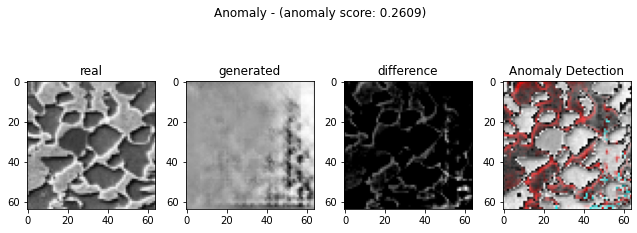

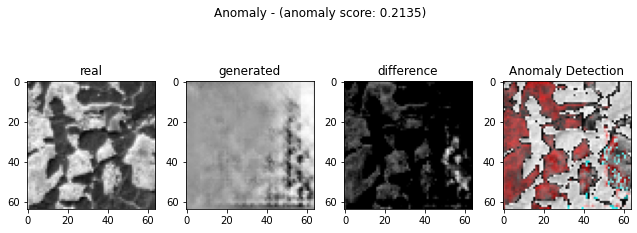

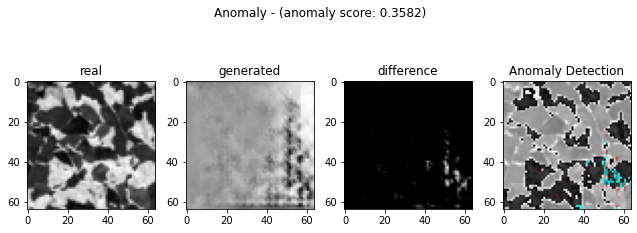

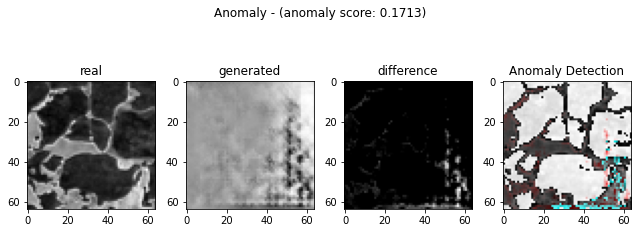

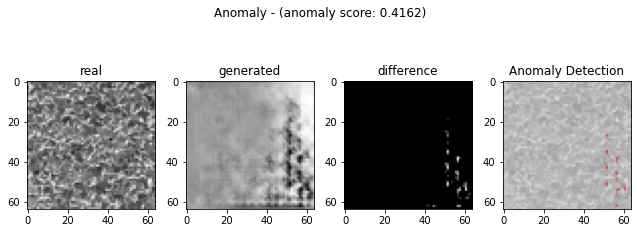

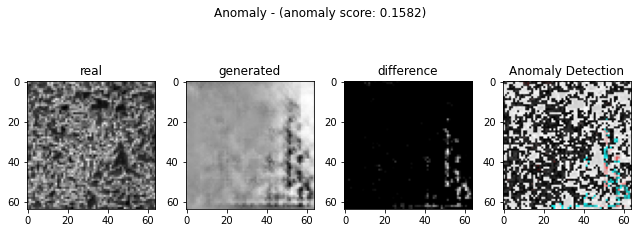

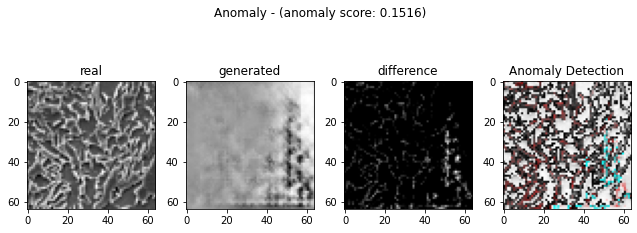

In [27]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [28]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.35131836 0.41674805 0.05444336 0.17871094 0.01855469 0.07055664
 0.23120117]


In [29]:
cal_corr_coeffis()

print(corr_coeffis)

[0.1831385831826695, 0.20072027804381065, 0.13222580393629021, 0.2930608194983925, 0.066183251941719, 0.3387781264476453, 0.17352231268057053]


---

# anomaly detection 이미지 추출

In [30]:
anomaly_imgs

[array([[[242, 242, 242],
         [246, 246, 246],
         [121,  16,  16],
         ...,
         [210, 210, 210],
         [176, 176, 176],
         [222, 222, 222]],
 
        [[248, 248, 248],
         [242, 242, 242],
         [ 87,  33,  33],
         ...,
         [238, 238, 238],
         [238, 238, 238],
         [190, 190, 190]],
 
        [[236, 236, 236],
         [230, 230, 230],
         [ 77,  61,  61],
         ...,
         [230, 230, 230],
         [232, 232, 232],
         [238, 238, 238]],
 
        ...,
 
        [[230, 230, 230],
         [248, 248, 248],
         [212, 212, 212],
         ...,
         [142, 142, 142],
         [ 85,  85,  85],
         [130, 130, 130]],
 
        [[228, 228, 228],
         [244, 244, 244],
         [230, 230, 230],
         ...,
         [105, 105, 105],
         [150, 150, 150],
         [252, 252, 252]],
 
        [[218, 218, 218],
         [228, 228, 228],
         [246, 246, 246],
         ...,
         [182, 182, 182],
  

# 이미지 저장 함수

In [31]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [32]:
save_imgs("./anomaly_imgs", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [33]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[1.55634033 1.84619385 0.24118408 0.79168945 0.08219727 0.31256592
 1.02422119]
